In [2]:
import os
import numpy as np
import pandas as pd
import imghdr
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [3]:
import os
import numpy as np
import pandas as pd
import imghdr
from PIL import Image
from tensorflow.keras.utils import to_categorical

def load_flavia_dataset_from_csv(csv_path, img_size, base_image_dir=None):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    X = []  # Images
    y = []  # Labels
    
    # Ensure we have the correct columns
    if 'id' not in df.columns or 'y' not in df.columns:
        raise ValueError("CSV must contain 'image path' and 'y' columns")
    
    # Track unique classes for naming
    class_names = df['y'].unique().tolist()
    
    # Iterate through rows in the dataframe
    for _, row in df.iterrows():
        # Construct full path if base_image_dir is provided
        img_path = row['id']
        if base_image_dir:
            img_path = os.path.join(base_image_dir, img_path)
        
        try:
            # Check if file exists
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue
            
            # Check if file is a valid image
            image_type = imghdr.what(img_path)
            if not image_type:
                print(f"Skipping invalid image: {img_path}")
                continue
            
            # Open image with PIL
            with Image.open(img_path) as img:
                # Convert to RGB if not already
                img = img.convert('RGB')
                
                # Resize image
                img = img.resize(img_size, Image.LANCZOS)
                
                # Convert to numpy array and normalize
                img_array = np.array(img) / 255.0
                
                X.append(img_array)
                y.append(row['y'])
        
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    # Check if any images were loaded
    if len(X) == 0:
        raise ValueError("No images could be loaded. Check file paths and image formats.")
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_onehot = to_categorical(y, num_classes=num_classes)
    
    print(f"Loaded {len(X)} images")
    return X, y, y_onehot, class_names

# Example usage
X, y, y_onehot, class_names = load_flavia_dataset_from_csv(
    '/kaggle/input/flavia-dataset/Leaves/all.csv', 
    (299, 299), 
    base_image_dir='/kaggle/input/flavia-dataset/Leaves')

Loaded 1907 images


In [4]:
 # Split data into training + validation set and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(
 X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
     )

# Split the training + validation set into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(
 X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
     )

In [5]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )
    

In [6]:
import os
import numpy as np
import pandas as pd
import imghdr
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


def create_xception_transfer_learning_model(input_shape, num_classes):
    # Load pre-trained Xception model
    base_model = Xception(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
 # Create and compile the model
model = create_xception_transfer_learning_model(
        input_shape=X.shape[1:], 
        num_classes=y_onehot.shape[1]
    )
    
    # Callbacks
reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-6, 
        verbose=1
    )
    
early_stopping = EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True
    )
    
    # Train the model
history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=100,
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train) // 32,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 834ms/step - accuracy: 0.1041 - loss: 3.3770 - val_accuracy: 0.5803 - val_loss: 2.7571 - learning_rate: 1.0000e-04
Epoch 2/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.1250 - loss: 3.1026

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1250 - loss: 3.1026 - val_accuracy: 0.6066 - val_loss: 2.7380 - learning_rate: 1.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 499ms/step - accuracy: 0.3907 - loss: 2.6978 - val_accuracy: 0.7607 - val_loss: 1.9536 - learning_rate: 1.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4688 - loss: 2.2504 - val_accuracy: 0.7508 - val_loss: 1.9337 - learning_rate: 1.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - accuracy: 0.5360 - loss: 2.0671 - val_accuracy: 0.8328 - val_loss: 1.3088 - learning_rate: 1.0000e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6875 - loss: 1.4026 - val_accuracy: 0.8328 - val_loss: 1.2962 - learning_rate: 1.0000e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - accuracy: 0.6630 - loss: 1.5389 - val_accuracy: 0.8787 - val_loss: 0.8815 - learning_rate: 1.0000e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6250

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=0)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
    
# Predict and generate a classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Final Test Loss: 0.0742
Final Test Accuracy: 98.69%
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00        13
           3       1.00      0.93      0.97        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        11
           6       1.00      0.83      0.91        12
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        12
          10       0.90      0.90      0.90        10
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        10
          13       0.93      1.00      0.96        13
          14       1.00      1.00      1.00        12
        

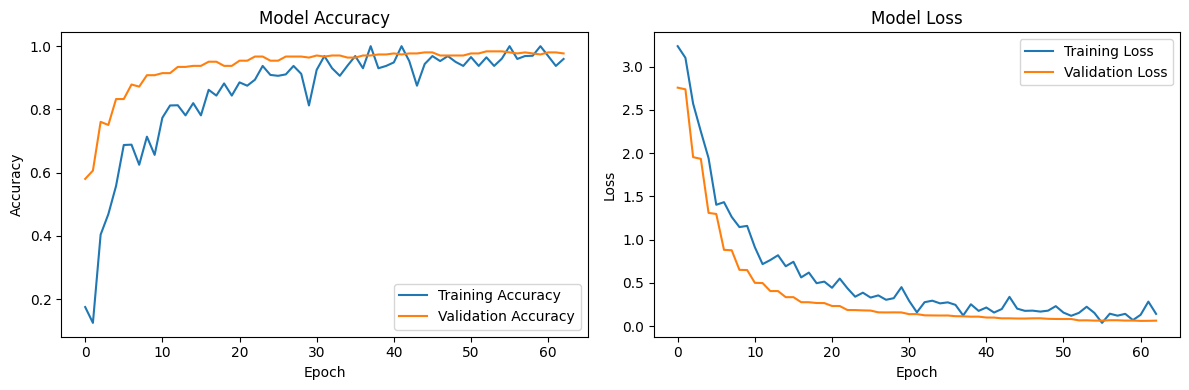

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Show plots
    plt.tight_layout()
    plt.savefig('training_history.png')  # Save the plot as a file if needed
    plt.show() 

plot_training_history(history)

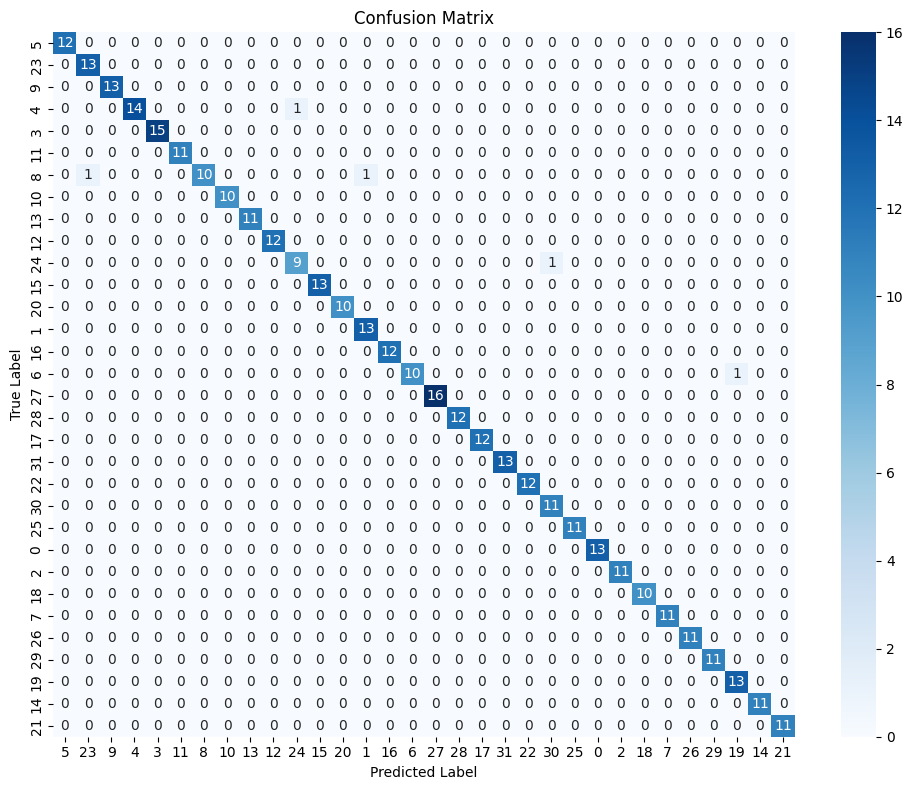

In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

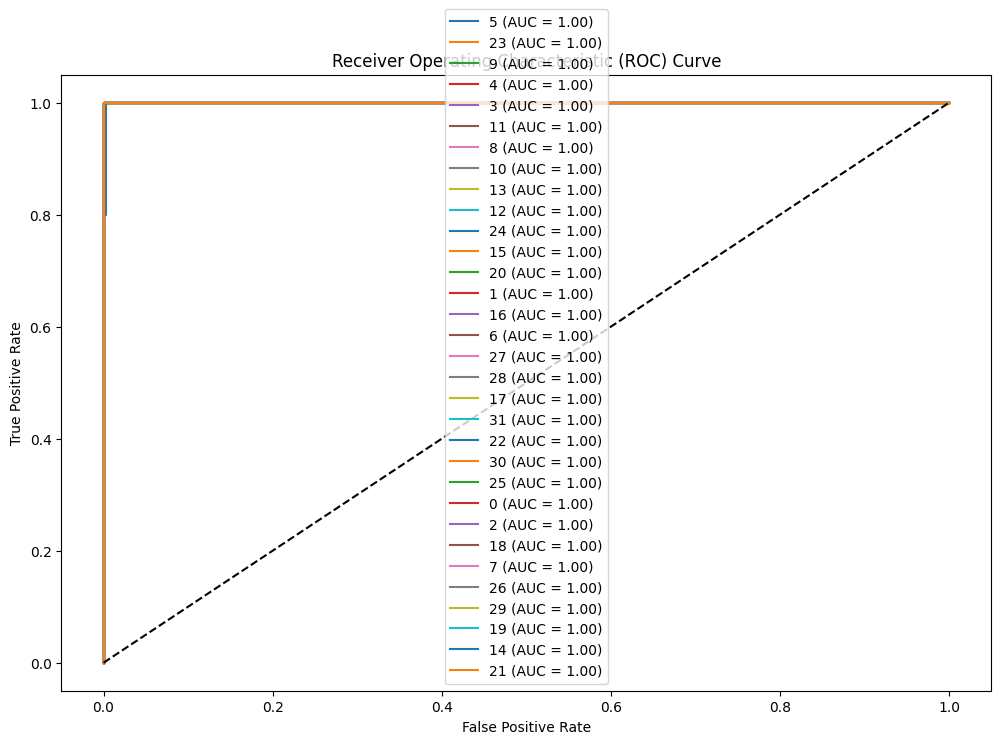

In [11]:
from sklearn.metrics import (precision_recall_curve, auc)

def plot_roc_curve(y_true, y_pred, class_names):

    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(
            y_true[:, i], 
            y_pred[:, i]
        )
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.show()

plot_roc_curve(y_test, y_pred, class_names)

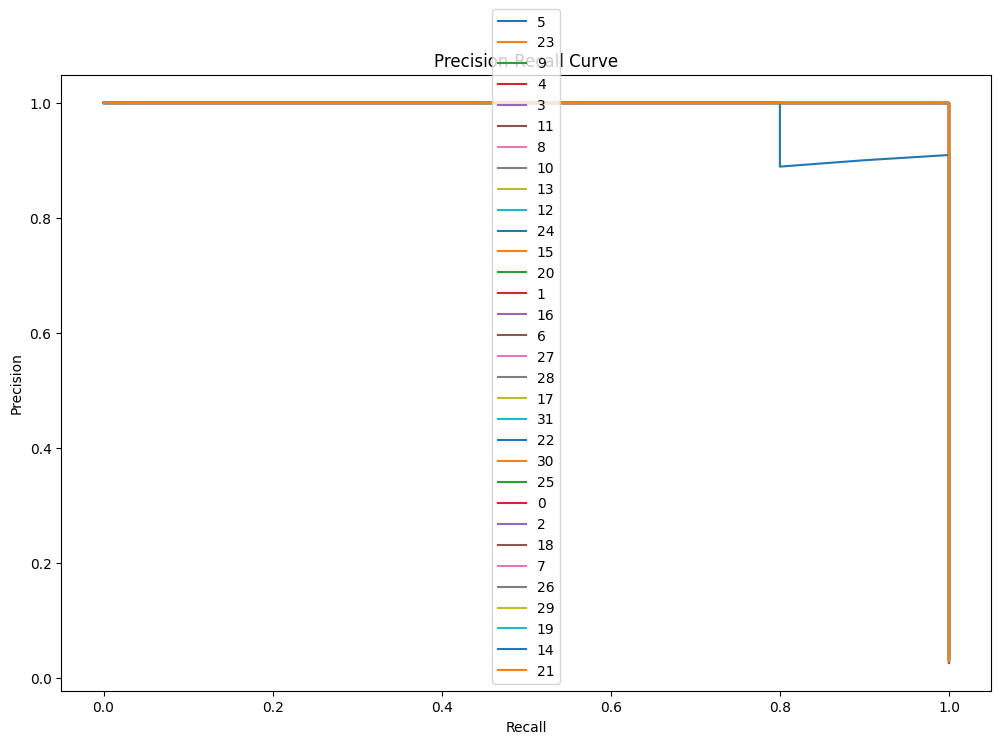

In [12]:
def plot_precision_recall_curve(y_true, y_pred, class_names):

    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(
            y_true[:, i], 
            y_pred[:, i]
        )
        plt.plot(recall, precision, label=f'{class_names[i]}')
    
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()

plot_precision_recall_curve(y_test, y_pred, class_names)